In [1]:
import os
import zipfile
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_path = os.path.dirname(os.path.abspath(''))
images_path = file_path + "/model/images/"

In [3]:
datetime.datetime.strptime("20220122233847", '%Y%m%d%H%M%S')

datetime.datetime(2022, 1, 22, 23, 38, 47)

In [4]:
images = []

for zipped_file in os.listdir(images_path):
    with zipfile.ZipFile(images_path + os.path.basename(zipped_file)) as zf:
        zip_year, zip_month, zip_day, zip_hour, zip_minute = map(int, zipped_file[:-4].split("_"))
        zip_date = datetime.datetime(zip_year, zip_month, zip_day)
        zip_datetime = datetime.datetime(zip_year, zip_month, zip_day, zip_hour, zip_minute)
        for image_name in zf.namelist():
            temp = image_name.split("_")
            camera_id = temp[0]
            image_datetime = datetime.datetime.strptime(temp[2], '%Y%m%d%H%M%S')
            images.append([zip_date, zip_datetime, camera_id, image_datetime])

In [5]:
df = pd.DataFrame(images, columns = ["zip_date", "zip_datetime", "camera_id", "image_datetime"])

# Questions to answer:
1. How many cameras do we have?
2. Are there duplicate rows in df?
3. Are the camera IDs in each zip file different?
4. Do we have complete days starting from 5 Jan to 23 Jan?
5. Which days / hours are incomplete (do not have all zip files every 5 mins)?
6. Which zip files are incomplete (do not have all 87 locations)?
7. Which camera ids are incomplete (do not have all zip_datetime)?
8. Are there duplicate images (same image_datetime has 2 zip_datetime)?
9. Are the image_datetime within the last 5 minutes of zip_datetime?

How many cameras do we have?

87

In [6]:
df["camera_id"].nunique()

87

Are there duplicate rows in df? 

No

In [7]:
df.equals(df.drop_duplicates())

True

Are the camera IDs in each zip file different? 

No

In [8]:
df.equals(df.drop_duplicates(subset = ["zip_datetime", "camera_id"]))

True

Do we have complete days starting from 5 Jan to 23 Jan?

No. We have 5 missing days from 15 Jan to 19 Jan

In [9]:
(df["zip_date"].max() - df["zip_date"].min()).days + 1 - df["zip_date"].nunique()

5

In [10]:
df["zip_date"].unique()

array(['2022-01-05T00:00:00.000000000', '2022-01-06T00:00:00.000000000',
       '2022-01-07T00:00:00.000000000', '2022-01-08T00:00:00.000000000',
       '2022-01-09T00:00:00.000000000', '2022-01-10T00:00:00.000000000',
       '2022-01-11T00:00:00.000000000', '2022-01-12T00:00:00.000000000',
       '2022-01-13T00:00:00.000000000', '2022-01-14T00:00:00.000000000',
       '2022-01-20T00:00:00.000000000', '2022-01-21T00:00:00.000000000',
       '2022-01-22T00:00:00.000000000', '2022-01-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

Which days / hours are incomplete (do not have all zip files every 5 mins)?

Only 5 days have all zip files every 5 mins

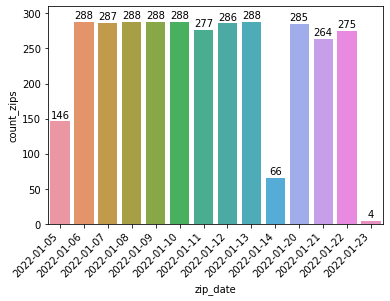

In [11]:
count_zip_files_per_day = df.groupby("zip_date").agg(count_zips = ("zip_datetime", 'nunique')).reset_index().sort_values("zip_date")

sns.barplot(x = count_zip_files_per_day["zip_date"].dt.strftime('%Y-%m-%d'), y = count_zip_files_per_day["count_zips"])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)

ax = plt.gca()
ax.set_ylim([0, 310])

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height() + 2, '%d' % int(p.get_height()), 
            fontsize=10, color='black', ha='center', va='bottom')

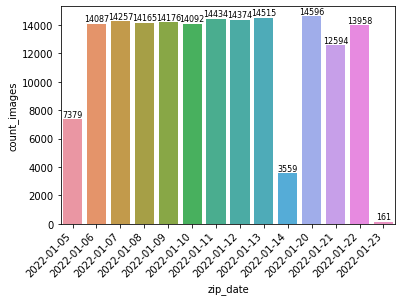

In [12]:
count_images_per_day = df.groupby("zip_date").agg(count_images = ("image_datetime", 'nunique')).reset_index().sort_values("zip_date")

sns.barplot(x = count_images_per_day["zip_date"].dt.strftime('%Y-%m-%d'), y = count_images_per_day["count_images"])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)

ax = plt.gca()
ax.set_ylim([0, 15300])

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height() + 2, '%d' % int(p.get_height()), 
            fontsize=8, color='black', ha='center', va='bottom')

Which zip files are incomplete (do not have all 87 locations)?

204 out of 3330 are incomplete

In [13]:
total_cameras = df["camera_id"].nunique()

zip_total_cameras = df.groupby(["zip_date", "zip_datetime"]).agg(count_camera_ids = ("camera_id", "count")).sort_values("count_camera_ids").reset_index()
incomplete_zip_files = zip_total_cameras[zip_total_cameras["count_camera_ids"] != total_cameras]

incomplete_zip_files

,zip_date,zip_datetime,count_camera_ids
0,2022-01-12,2022-01-12 09:30:00,2
1,2022-01-10,2022-01-10 22:40:00,3
2,2022-01-13,2022-01-13 21:40:00,4
3,2022-01-13,2022-01-13 20:40:00,4
4,2022-01-13,2022-01-13 20:20:00,4
...,...,...,...
199,2022-01-11,2022-01-11 22:00:00,86
200,2022-01-05,2022-01-05 15:30:00,86
201,2022-01-05,2022-01-05 18:35:00,86
202,2022-01-05,2022-01-05 18:30:00,86


<AxesSubplot:xlabel='count_camera_ids', ylabel='Count'>

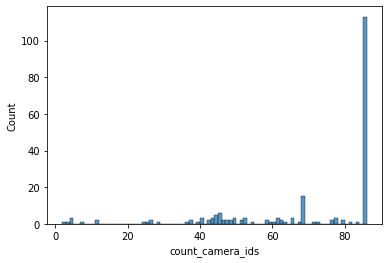

In [14]:
sns.histplot(incomplete_zip_files["count_camera_ids"], binwidth = 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, '2022-01-05'),
  Text(1, 0, '2022-01-06'),
  Text(2, 0, '2022-01-07'),
  Text(3, 0, '2022-01-08'),
  Text(4, 0, '2022-01-09'),
  Text(5, 0, '2022-01-10'),
  Text(6, 0, '2022-01-11'),
  Text(7, 0, '2022-01-12'),
  Text(8, 0, '2022-01-13'),
  Text(9, 0, '2022-01-14'),
  Text(10, 0, '2022-01-20'),
  Text(11, 0, '2022-01-21'),
  Text(12, 0, '2022-01-22'),
  Text(13, 0, '2022-01-23')])

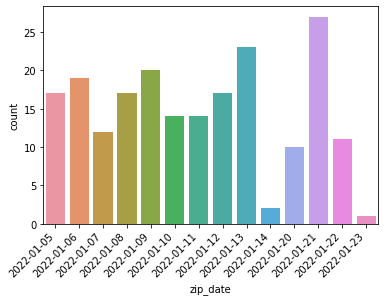

In [15]:
sns.countplot(x = incomplete_zip_files.sort_values("zip_date")["zip_date"].dt.strftime('%Y-%m-%d'))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)

In [16]:
incomplete_zip_files["zip_hour"] = incomplete_zip_files["zip_datetime"].apply(lambda x: x.hour)

C:\Users\clift\AppData\Local\Temp/ipykernel_41824/3493726243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_zip_files["zip_hour"] = incomplete_zip_files["zip_datetime"].apply(lambda x: x.hour)


<AxesSubplot:xlabel='zip_hour', ylabel='count'>

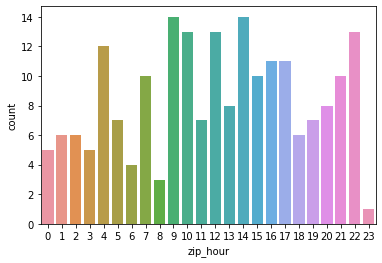

In [17]:
sns.countplot(x = incomplete_zip_files.sort_values("zip_hour")["zip_hour"])

In [18]:
incomplete_zip_files.groupby(["zip_date", "zip_hour"]).agg(count_incomplete_zips = ("zip_datetime", "count"))\
    .reset_index().sort_values("count_incomplete_zips", ascending = False)

,zip_date,zip_hour,count_incomplete_zips
109,2022-01-21,4,11
25,2022-01-07,9,5
13,2022-01-06,9,4
71,2022-01-11,22,4
8,2022-01-05,22,4
...,...,...,...
44,2022-01-09,10,1
42,2022-01-09,2,1
41,2022-01-09,0,1
40,2022-01-08,23,1


Which camera ids are incomplete (do not have all zip_datetime)?

No camera exists in all 3330 zip files

In [19]:
df.groupby("camera_id").agg(count_zip_files = ("zip_datetime", 'count')).reset_index().sort_values("count_zip_files")

,camera_id,count_zip_files
82,9702,3255
83,9703,3258
86,9706,3259
80,8706,3259
85,9705,3260
...,...,...
13,1703,3309
21,2702,3309
5,1006,3309
15,1705,3310


Are there duplicate images (same image_datetime has 2 zip_datetime)?

41438 images appear more than 1 time, around 200k appear 1 time only

In [20]:
image_total_zip_files = df.groupby(["camera_id", "image_datetime"]).agg(count_zip_files = ("zip_datetime", "count"))\
    .reset_index().sort_values("count_zip_files")

print(len(image_total_zip_files))

244047


In [21]:
image_total_zip_files[image_total_zip_files["count_zip_files"] > 1]

,camera_id,image_datetime,count_zip_files
2729,1001,2022-01-22 14:14:27,2
18782,1501,2022-01-13 02:59:17,2
217355,8701,2022-01-10 12:29:21,2
110525,4704,2022-01-08 18:17:13,2
217307,8701,2022-01-10 07:03:46,2
...,...,...,...
44671,1705,2022-01-21 03:35:16,14
41853,1704,2022-01-21 03:35:16,14
92482,3795,2022-01-21 03:35:54,14
123368,4708,2022-01-21 03:36:55,14


In [22]:
df[(df["image_datetime"] == "2022-01-21 03:35:15") & (df["camera_id"] == '1702')] #appear in 14 zip files

,zip_date,zip_datetime,camera_id,image_datetime
243586,2022-01-21,2022-01-21 03:45:00,1702,2022-01-21 03:35:15
243654,2022-01-21,2022-01-21 03:50:00,1702,2022-01-21 03:35:15
243722,2022-01-21,2022-01-21 03:55:00,1702,2022-01-21 03:35:15
243790,2022-01-21,2022-01-21 04:00:00,1702,2022-01-21 03:35:15
243858,2022-01-21,2022-01-21 04:05:00,1702,2022-01-21 03:35:15
243926,2022-01-21,2022-01-21 04:10:00,1702,2022-01-21 03:35:15
243994,2022-01-21,2022-01-21 04:15:00,1702,2022-01-21 03:35:15
244062,2022-01-21,2022-01-21 04:20:00,1702,2022-01-21 03:35:15
244130,2022-01-21,2022-01-21 04:25:00,1702,2022-01-21 03:35:15
244198,2022-01-21,2022-01-21 04:30:00,1702,2022-01-21 03:35:15


Are the image_datetime within the last 5 minutes of zip_datetime?

Most of the images are within the last 10 minutes from zip_datetime. Only 1180 images are before 10 minutes from zip_datetime. 

It means that eventhough the API documentation says that the image will be updated every 1 - 5 mins, some images are not updated after 5 mins

In [23]:
df["image_zip_time_difference"] = df["zip_datetime"] - df["image_datetime"]

In [24]:
df["image_zip_time_difference"].max()

Timedelta('0 days 01:15:00')

In [25]:
df[df["image_zip_time_difference"].dt.seconds > 600]

,zip_date,zip_datetime,camera_id,image_datetime,image_zip_time_difference
50130,2022-01-07,2022-01-07 12:45:00,1001,2022-01-07 12:34:57,0 days 00:10:03
50131,2022-01-07,2022-01-07 12:45:00,1002,2022-01-07 12:34:57,0 days 00:10:03
50132,2022-01-07,2022-01-07 12:45:00,1003,2022-01-07 12:34:57,0 days 00:10:03
50133,2022-01-07,2022-01-07 12:45:00,1004,2022-01-07 12:34:56,0 days 00:10:04
50134,2022-01-07,2022-01-07 12:45:00,1005,2022-01-07 12:34:56,0 days 00:10:04
...,...,...,...,...,...
256404,2022-01-21,2022-01-21 18:25:00,4703,2022-01-21 18:14:28,0 days 00:10:32
256405,2022-01-21,2022-01-21 18:25:00,4704,2022-01-21 18:14:43,0 days 00:10:17
256406,2022-01-21,2022-01-21 18:25:00,4705,2022-01-21 18:14:46,0 days 00:10:14
256407,2022-01-21,2022-01-21 18:25:00,4706,2022-01-21 18:14:46,0 days 00:10:14


<AxesSubplot:xlabel='image_zip_time_difference', ylabel='Count'>

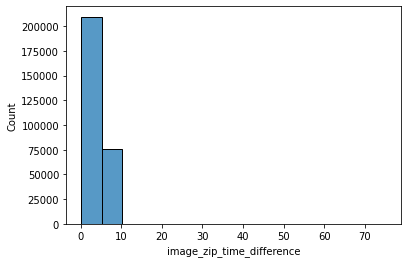

In [26]:
sns.histplot(df["image_zip_time_difference"].apply(lambda x: x.seconds / 60), binwidth = 5)